In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate Vexp

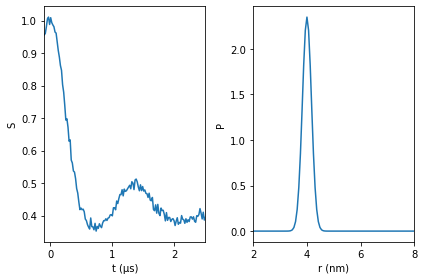

In [2]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,8,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
Ptrue = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

# param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
# Ptrue = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod = lam, bg = B)    # kernel matrix

sigma = 0.01

# Vtrue = dive.deerTrace(K@P0,B,V0,lam)
Vtrue = K@Ptrue
Vexp = Vtrue + dl.whitegaussnoise(t,sigma,seed=0)

# Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
# line1 = ax[0].plot(t, Vtrue,'k')
line2 = ax[1].plot(r, Ptrue)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

10000.0


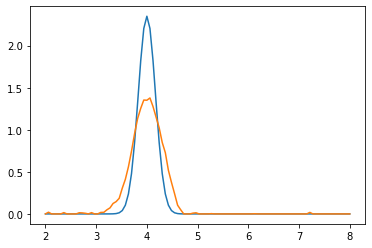

In [3]:
KtK1 = np.matmul(np.transpose(K),K)
KtS1 = np.matmul(np.transpose(K),Vexp)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL1 = np.matmul(np.transpose(L),L)

tau = 1/(sigma**2)
delta = 1000

print(tau)

Pdraw1 = dive.randP(delta,tau,KtK1,KtS1,LtL1,nr)
Pdraw1 = Pdraw1/sum(Pdraw1)/(r[1]-r[0])

plt.plot(r,Ptrue)
plt.plot(r,Pdraw1);

### We need to use the deerlab function to build the kernel that includes the background every step
Unfortunately, dl.dipolarkernel() can not be used in the model itself, hence, we have to build our own copy of it

In [4]:
import warnings
import scipy.integrate
from scipy.special import fresnel

def kernelmatrix_fresnel(t,r):

    ge = 2.00231930436256 # free-electron g factor
    muB = 9.2740100783e-24 # Bohr magneton, J/T 
    mu0 = 1.25663706212e-6 # magnetic constant, N A^-2 = T^2 m^3 J^-1 
    h = 6.62607015e-34 # Planck constant, J/Hz
    w0 = (mu0/2)*muB**2*ge*ge/h*1e21 # Hz m^3 -> MHz nm^3 -> Mrad s^-1 nm^3
    
    #==========================================================================
    """Calculate kernel using Fresnel integrals (fast and accurate)"""
    K = np.zeros((nt,nr))
    wr = w0/(r**3)  # rad s^-1

    # Calculation using Fresnel integrals
    ph = np.outer(np.abs(t), wr)
    kappa = np.sqrt(6*ph/np.pi)
    
    # Supress divide by 0 warning        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        S, C = fresnel(kappa)/kappa
    
    K = C*np.cos(ph) + S*np.sin(ph)
    K[t==0] = 1 

    return K

(150, 100)

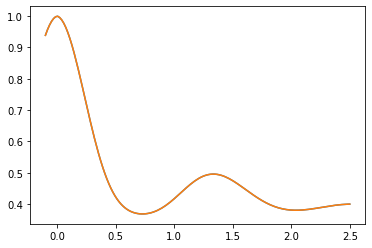

In [5]:
# Verify that dl.dipolarkernel() and the self-built one give the same results
B = dl.bg_exp(t,k)
Bm = np.transpose(np.tile(B,(nr,1)))
Kl = (1-lam)+lam*kernelmatrix_fresnel(t,r)    # kernel matrix 
KB = np.multiply(Kl,Bm)

dr = r[1]-r[0]
KB = KB*dr

Vnew = KB@Ptrue

# Vnew = (KB)@Ptrue
plt.plot(t,Vtrue)
plt.plot(t,Vnew);

np.shape(Bm)

10000.0


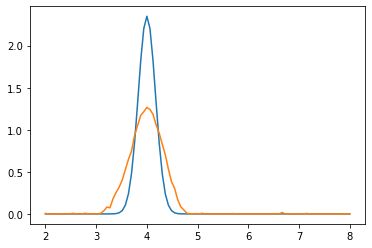

In [6]:
# Make a random draw to make sure the method works
delta = 2000
tau = 1/(sigma**2)
print(tau)

KtK2 = np.matmul(np.transpose(KB),KB)
KtV2 = np.matmul(np.transpose(KB),Vexp)
rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL2 = np.matmul(np.transpose(L),L)

Pdraw2 = dive.randP(delta,tau,KtK1,KtS1,LtL1,nr)

Pdraw2 = Pdraw2/np.sum(Pdraw2)/(r[1]-r[0])


plt.plot(r,Ptrue)
plt.plot(r,Pdraw2);



### Setup model

In [7]:
K = kernelmatrix_fresnel(t,r)    # unnormalized kernel matrix
dr = r[1]-r[0]

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

a0 = 0.01
b0 = 1e-6

Pmap = Ptrue

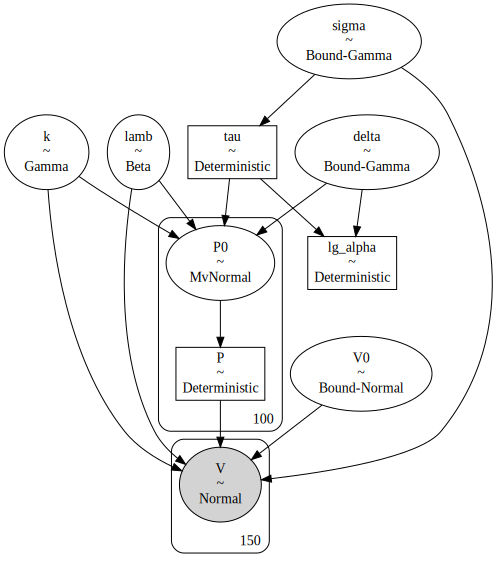

In [32]:
with pm.Model() as model:
    # Noise
    sigma = pm.Bound(pm.Gamma,lower = 0.005, upper = 0.1)('sigma', alpha=0.7, beta=2)
    # sigma = 0.01
    tau = pm.Deterministic('tau',1/(sigma**2))
    # tau = 1/(sigma**2)

    # time domainnal
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    
    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t,k)         # background decay

    # Calculate matrices and operators
    K1 = (1-lamb)+lamb*K
    Bm = T.transpose(T.tile(B,(nr,1)))
    KB = K1*Bm*dr
    KtK = T.dot(T.transpose(KB),KB)

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Bound(pm.Gamma,lower = 50, upper = 10000)('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Likelihood
    pm.Normal('V',mu = V0*pm.math.dot(KB,P), sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

### Add custom sampling step for P

In [30]:
from pymc3.step_methods.arraystep import BlockedStep
import time

class SampleRandP(BlockedStep):
    def __init__(self, var, delta, sigma, k, lamb, LtL, t, V, r):
            self.vars = [var]
            self.var = var
            self.delta = delta
            self.sigma = sigma
            self.k = k
            self.lamb = lamb
            self.LtL = LtL
            self.nr = nr
            self.V = V
            self.r = r
            self.t = t

    def step(self, point: dict):
        # transform parameters
        sigma = np.exp(point[self.sigma.transformed.name])
        # sigma = self.sigma
        tau = 1/(sigma**2)
        delta = np.exp(point[self.delta.transformed.name])
        k = np.exp(point[self.k.transformed.name])
        lamb = np.exp(point[self.lamb.transformed.name])

        nr = len(self.r)

        # Background
        B = dl.bg_exp(self.t,k) 
        # Kernel
        K = dl.dipolarkernel(self.t, self.r, mod = lamb, bg = B)

        KtK = np.matmul(np.transpose(K),K)
        KtV = np.matmul(np.transpose(K),self.V)

        new = point.copy()
        Pdraw = dive.randP(delta,tau,KtK,KtV,self.LtL,nr)
        new[self.var.name] = Pdraw

        plt.plot(r,Pdraw)
        plt.show()
        display(sigma,delta)

        return new

### Run sampler

Sequential sampling (3 chains in 1 job)
CompoundStep
>SampleRandP: [P0]
>NUTS: [delta, k, V0, lamb, sigma]


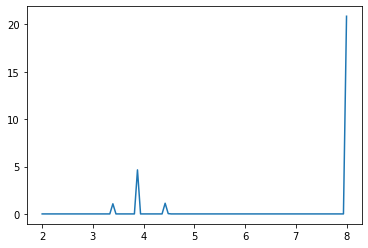

0.055555555555555566

0.005050505050505055

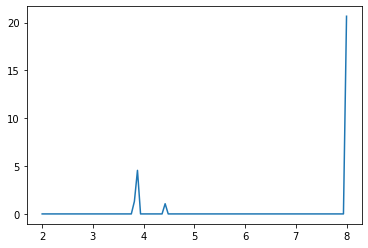

0.055555555555555566

0.005050505050505055

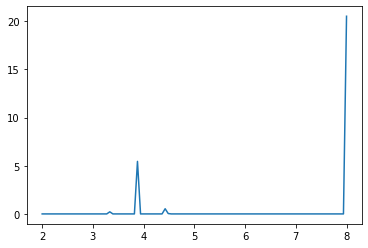

0.055555555555555566

0.005050505050505055

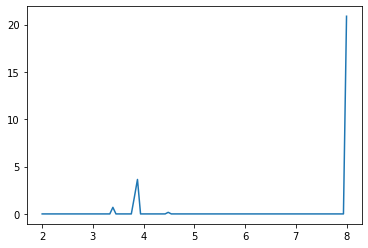

0.055555555555555566

0.005050505050505055

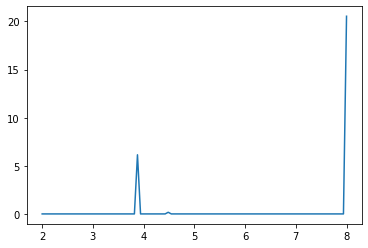

0.055555555555555566

0.005050505050505055

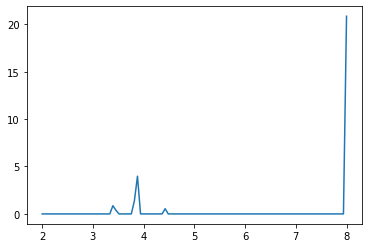

0.05635253503471213

0.005046702846105039

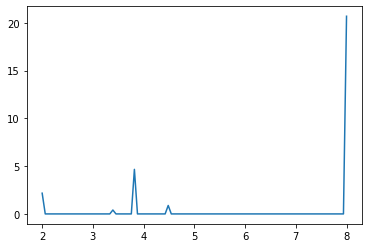

0.06976092239734331

0.004954956962751773

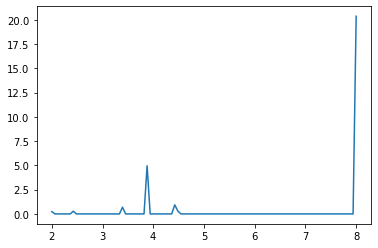

0.07290192358732826

0.004930436949795004

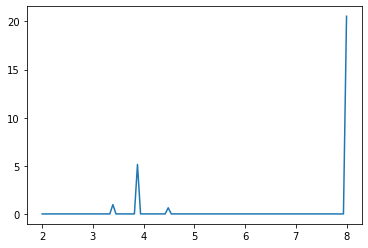

0.07290192358732826

0.004930436949795004

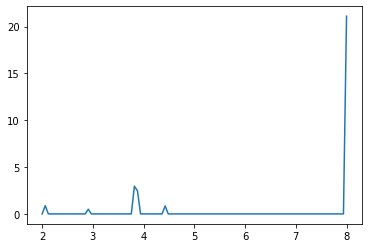

0.07294337864232406

0.004928970226298834

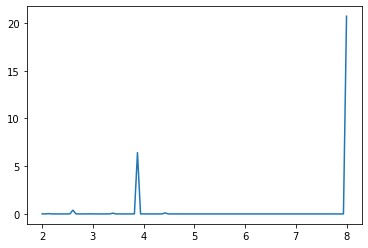

0.07353740718050615

0.004921338426887328

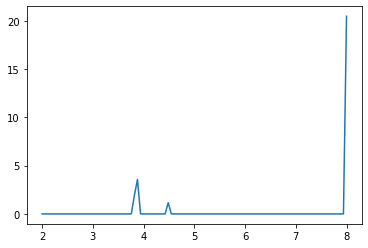

0.07538658208572156

0.004907782403642577

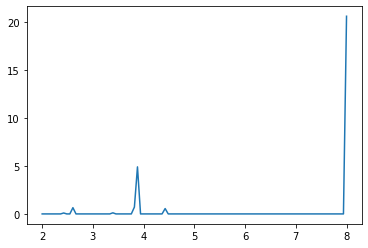

0.10329133642610629

0.004728125226087595

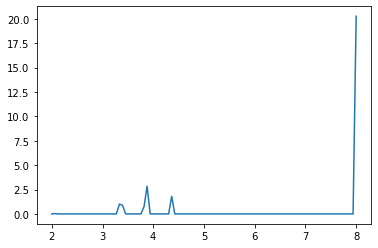

0.10937616208110003

0.004679512685280819

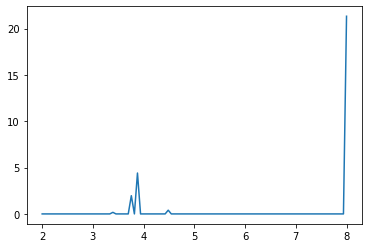

0.10937616208110003

0.004679512685280819

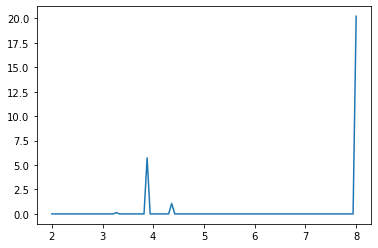

0.10953572168358675

0.004677611892929137

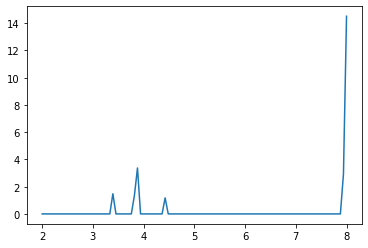

0.11872198597327575

0.004591662477068146

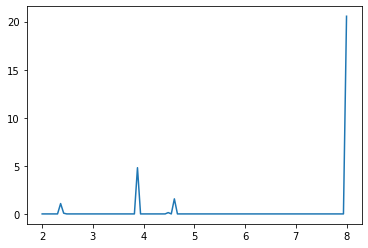

0.12454437936325079

0.004566428124946263

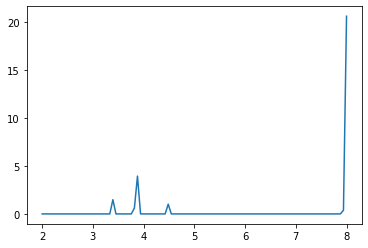

0.13346919153414596

0.00449764845558651

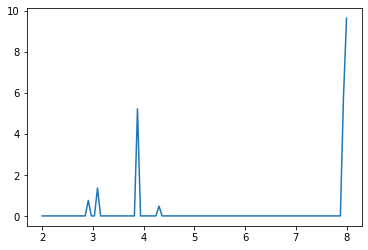

0.13346919153414596

0.00449764845558651

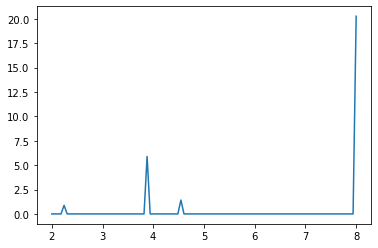

0.13357573217246937

0.004497092875597445

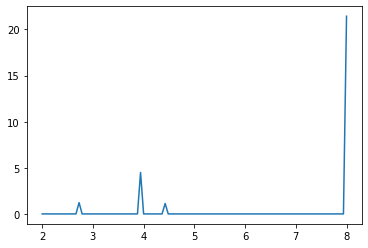

0.13776575526050833

0.004457432185777811

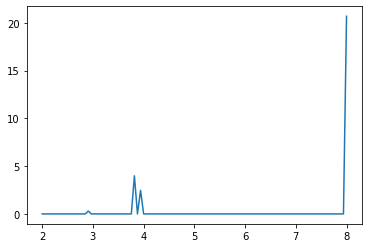

0.1417997451733176

0.004425475608017877

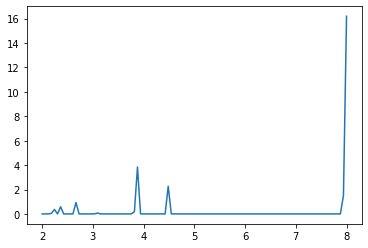

0.15528170293601617

0.004324692757198113

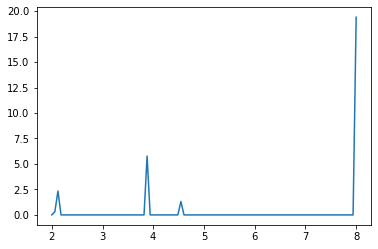

0.15528170293601617

0.004324692757198113

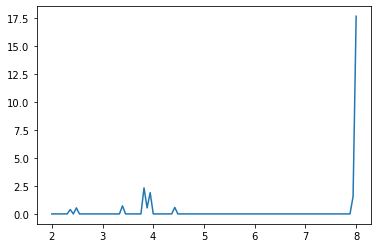

0.1635374158853985

0.004256900737612913

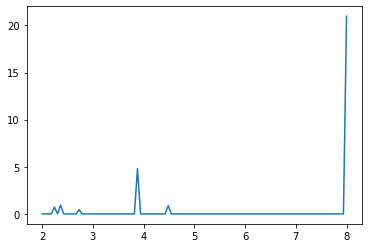

0.16489276645974663

0.004242480529175152

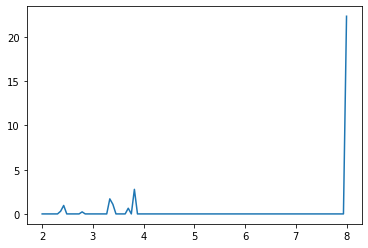

0.17143572584936312

0.004200368194855853

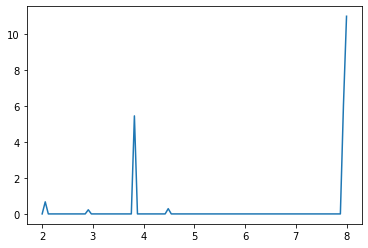

0.17143572584936312

0.004200368194855853

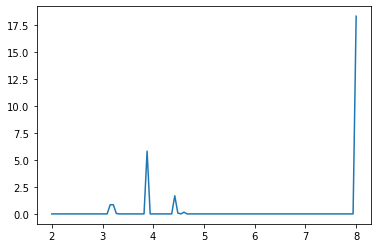

0.17157078068473236

0.0041997369111061505

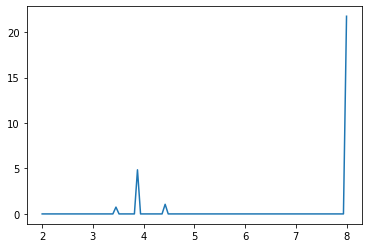

0.1723459999607972

0.004196971700858548

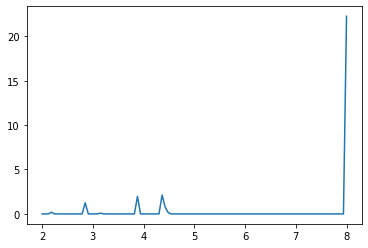

0.17577093609465014

0.004166232872329591

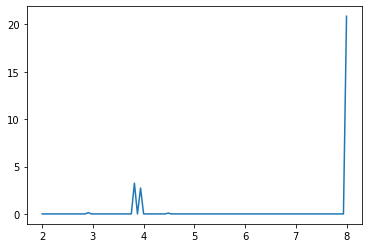

0.1882224013307088

0.004086882275844782

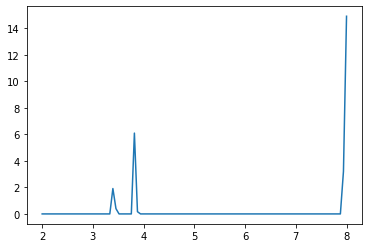

0.1882224013307088

0.004086882275844782

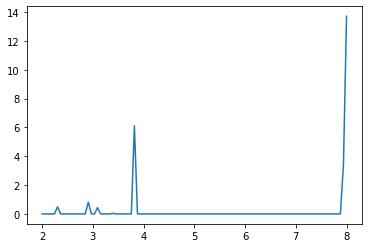

0.18861165863501428

0.004085018778201098

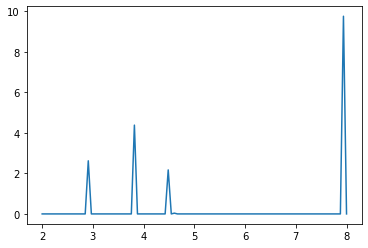

0.2053981811773028

0.004011207698973634

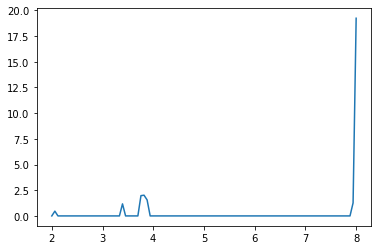

0.21235741353042842

0.003860225790575825

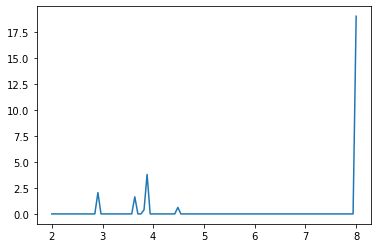

0.22793132442807132

0.0037742402827670948

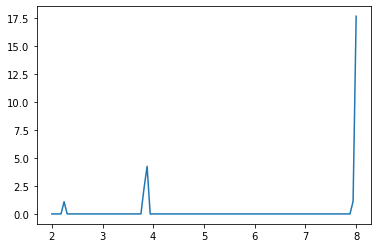

0.22793132442807132

0.0037742402827670948

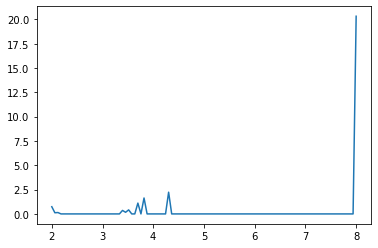

0.22861448437432064

0.003770247684424812

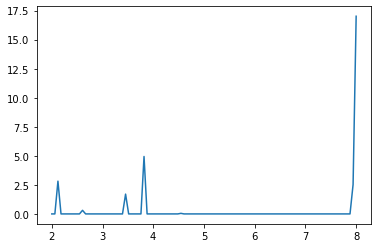

0.2310423069556134

0.0037519146451359714

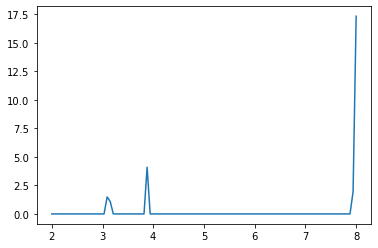

0.2395009623115482

0.0037245393381048738

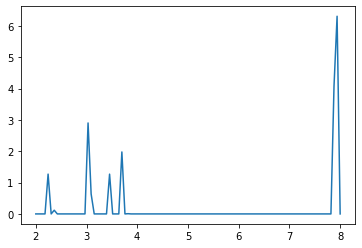

0.25911508615839546

0.0036199032024759755

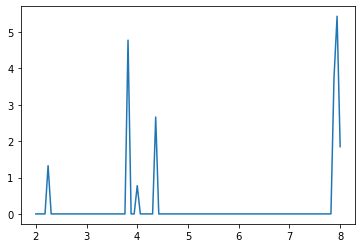

0.2697316867797273

0.003541537356827091

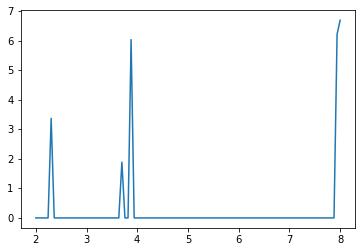

0.4706775686809603

0.0026529412957162755

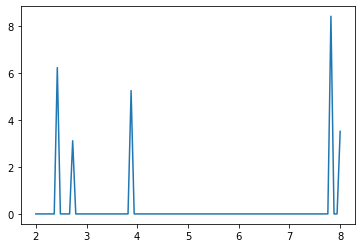

0.6949955655101497

0.0020835281007596865

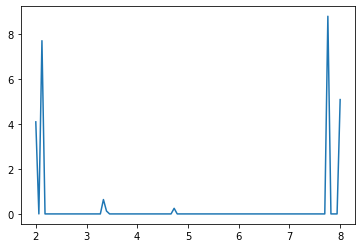

0.6949955655101497

0.0020835281007596865

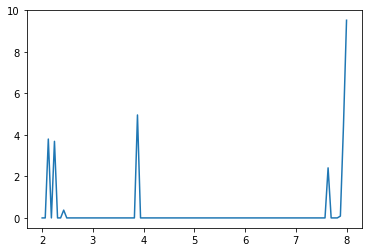

0.7078603934667534

0.002027122305026783

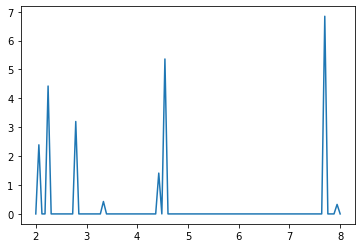

0.7635493240552752

0.0019685008252765127

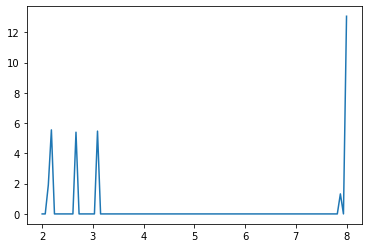

0.808229754052004

0.00170664183512195

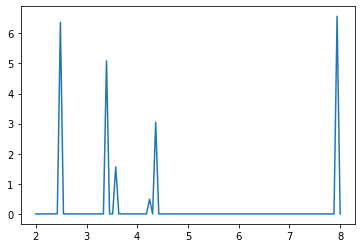

0.808229754052004

0.00170664183512195

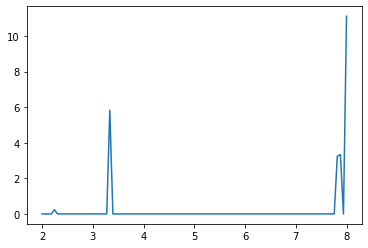

0.8087717384055657

0.0016934865733740192

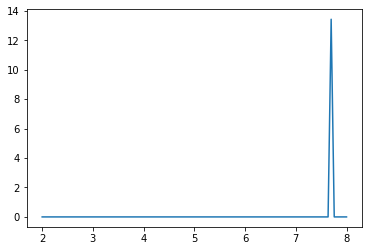

0.8295854652608345

0.0016591699120647454

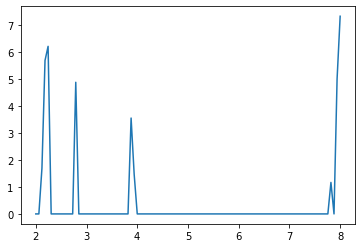

0.8448431683511126

0.0015115360392434578

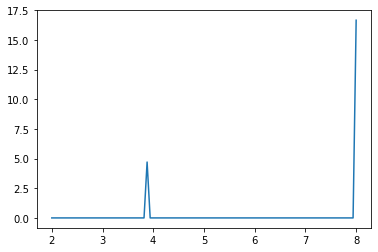

0.8448431683511126

0.0015115360392434578

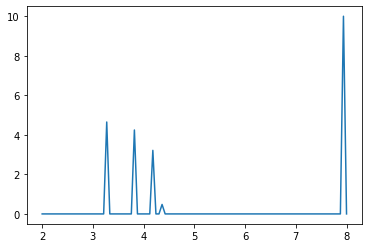

0.8467822885619894

0.0015045670007403885

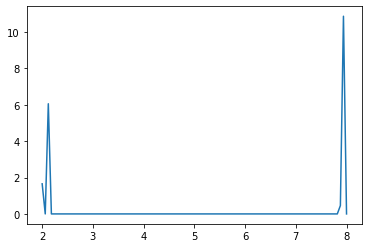

1.0326147035422288

0.000865310262347058

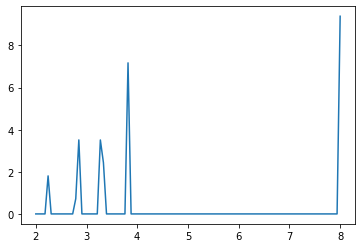

1.0387302658895354

0.0008504671473187221

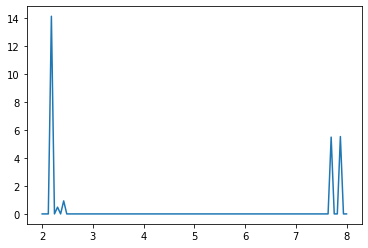

1.8462906917694675

0.000550138128447014

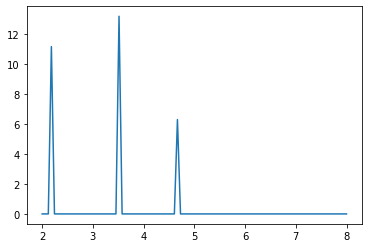

2.4070868351721897

0.0002898955306132825

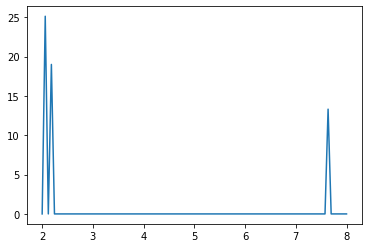

2.763940373874084

0.00021290569459466298

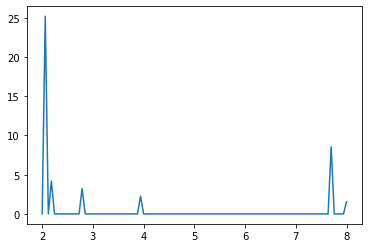

2.763940373874084

0.00021290569459466298

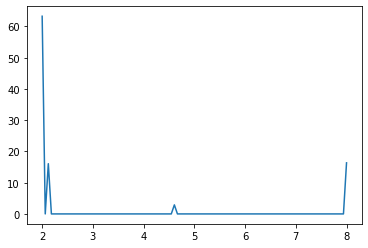

2.877524769135013

0.00020667049438598218

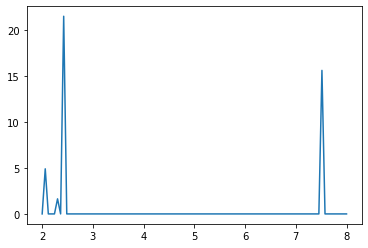

2.877524769135013

0.00020667049438598218

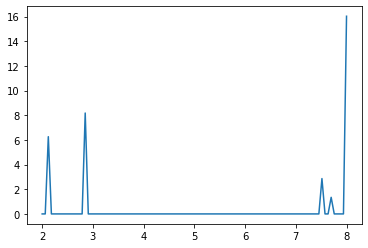

2.8874742429040845

0.00020550943341882057

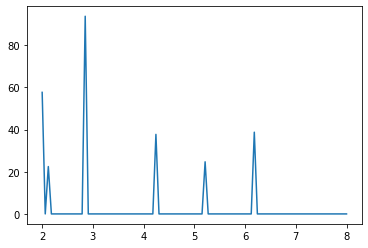

16.437133303110215

8.158705665215033e-05

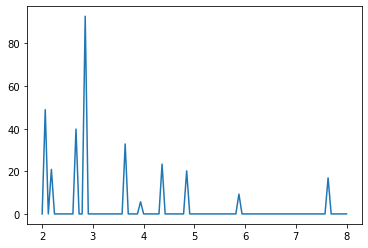

16.437133303110215

8.158705665215033e-05

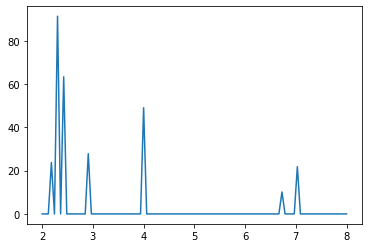

16.57665384820294

8.084459089630671e-05

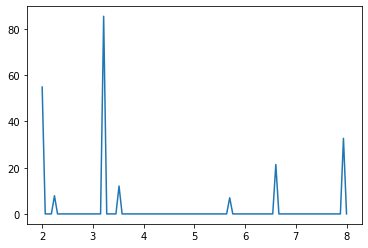

16.929308091035132

7.89867622598084e-05

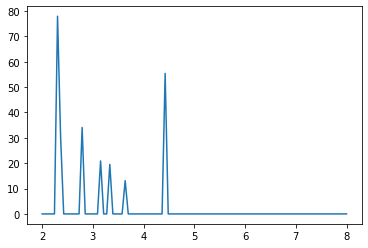

17.593272800180817

7.585107657689336e-05

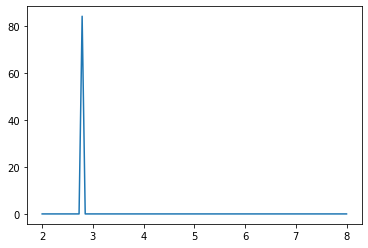

17.593272800180817

7.585107657689336e-05

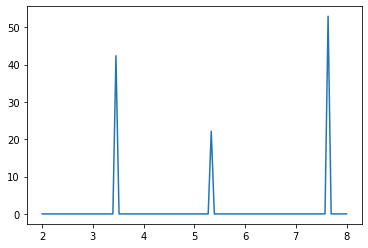

17.609127092863833

7.578713877831643e-05

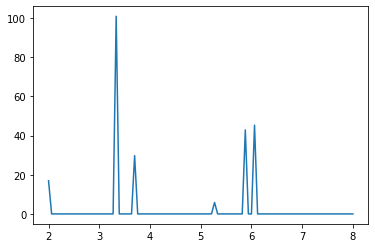

34.46063013438561

3.289035019423913e-05

In [33]:
startvalues = {'k': 0.1, 'lamb':0.5, 'delta': 100, 'sigma': 0.01}

with model:
    step_P0 = SampleRandP(P0, delta, sigma, k, lamb, LtL, t, Vexp, r)  
    trace = pm.sample(step = step_P0, chains=3, cores=1, draws=3000, tune=10000,return_inferencedata=False, start = startvalues)

### Analysis

In [5]:
dive.summary(trace, model, Vexp, t, r, Ptrue = Pmap)

NameError: name 'trace' is not defined